# Reference points


## Question

Do reference points have comparable positions among all structures?

## Experiment

* Centroid: Distances of centroids with respect to reference centroid
* Hinge/DFG region: Distances of reference points to the 3 residues of hinge/DFG region
* Front region: ?

## Imports

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [3]:
from itertools import combinations
from pathlib import Path
import sys

import matplotlib.pyplot as plt
import pandas as pd
import scipy

sys.path.append('../..')
from kinsim_structure.auxiliary import KlifsMoleculeLoader
from kinsim_structure.encoding import SpatialFeatures

In [4]:
pd.set_option('display.max_rows', 100)

## IO paths

In [5]:
path_to_kinsim = Path('/') / 'home' / 'dominique' / 'Documents' / 'Projects' / 'kinsim_structure'
path_to_data = Path('/') / 'home' / 'dominique' / 'Documents' / 'data' / 'kinsim' / '20190724_full'

path_to_results = path_to_kinsim / 'examples'/ 'results'

metadata_path = path_to_data / 'postprocessed' / 'klifs_metadata_postprocessed.csv'

## Load metadata

In [6]:
klifs_metadata = pd.read_csv(metadata_path, index_col=0)
klifs_metadata.set_index('metadata_index', drop=True, inplace=True)
klifs_metadata.head()

,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,ligand_allosteric_name,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
metadata_index,,,,,,,,,,,,,,,,,,,,,
2886,AAK1,NAK,Other,4wsq,B,A,Human,K-252A,KSA,-,...,in,0.777,2.125,8.6,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.95,0,14,0000000000000010000001000000000000000000000000...,HUMAN/AAK1/4wsq_chainB_altA
10043,AAK1,NAK,Other,5l4q,A,A,Human,"~{N}-[5-(4-cyanophenyl)-1~{H}-pyrrolo[2,3-b]py...",LKB,-,...,in,0.780,2.137,9.7,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.97,0,3,0000000000000010000000000000000000000000000000...,HUMAN/AAK1/5l4q_chainA_altA
7046,AAK1,NAK,Other,5te0,A,-,Human,methyl (3Z)-3-{[(4-{methyl[(4-methylpiperazin-...,XIN,-,...,in,0.776,2.120,8.8,EVLAEGGFAIVFLCALKRMVCKREIQIMRDLSKNIVGYIDSLILMD...,1.90,0,12,1000101000000010000001000000000000000000000000...,HUMAN/AAK1/5te0_chainA
843,ABL1,Abl,TK,2f4j,A,-,Human,CYCLOPROPANECARBOXYLIC ACID {4-[4-(4-METHYL-PI...,VX6,-,...,in,0.779,2.128,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.91,0,0,0000000000000010000001000000000000000000000000...,HUMAN/ABL1/2f4j_chainA
815,ABL1,Abl,TK,2g1t,A,-,Human,-,-,-,...,out,0.825,2.154,8.0,HKLGGGQYGEVYEVAVKTLEFLKEAAVMKEIKPNLVQLLGVYIITE...,1.80,0,0,NaN,HUMAN/ABL1/2g1t_chainA


## Reference structure `2wo6_A`

In [7]:
# Technically reference structure is 2wo6, chain A, alternate model A but only B/B is in dataset
klifs_metadata_reference = klifs_metadata[klifs_metadata.pdb_id == '2wo6']
klifs_metadata_reference

,kinase,family,groups,pdb_id,chain,alternate_model,species,ligand_orthosteric_name,ligand_orthosteric_pdb_id,ligand_allosteric_name,...,ac_helix,rmsd1,rmsd2,qualityscore,pocket,resolution,missing_residues,missing_atoms,full_ifp,code
metadata_index,,,,,,,,,,,,,,,,,,,,,
2818,DYRK1A,DYRK,CMGC,2wo6,B,B,Human,N-(5-{[(2S)-4-amino-2-(3-chlorophenyl)butanoyl...,D15,-,...,in,0.775,2.11,8.0,SLIGKGSFGQVVKVAIKIIQAQIEVRLLELMNYYIVHLKRHCLVFE...,2.5,0,0,0000000000000010000001000000100000010000000000...,HUMAN/DYRK1A/2wo6_chainB_altB


In [8]:
klifs_metadata_reference.index[0]

2818

In [9]:
def get_cgo_filename_from_metadata_index(metadata_index):
    
    klifs_metadata_entry=klifs_metadata.loc[metadata_index]
    ml = KlifsMoleculeLoader(klifs_metadata_entry=klifs_metadata_entry)
    
    filename = ml.file_from_metadata_entry(klifs_metadata_entry=klifs_metadata_entry)
    
    return f'refpoints_{filename.parent.parent.stem}_{filename.parent.stem}.py'

In [10]:
get_cgo_filename_from_metadata_index(klifs_metadata_reference.index[0])

'refpoints_DYRK1A_2wo6_altB_chainB.py'

## Get reference points

Get the coordinates for 4 reference points per structure.

In [11]:
def get_reference_points(klifs_metadata):
    
    reference_points = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        
        # Calculate spatial features
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        # Get reference points and save to dict with metadata index as key
        reference_points[row.metadata_index] = spatial.reference_points
        
    # Concatenate data from all structures
    reference_points = pd.concat(reference_points, axis=0)
    reference_points.index.set_names(['id', 'coordinate'], inplace=True)
    
    return reference_points

In [12]:
reference_points = pd.read_csv(
    path_to_results / 'reference_points' / 'coordinates_reference_points.csv',
    index_col=['id', 'coordinate']
)
print(reference_points.shape)
reference_points.head()

(11634, 4)


centroid  hinge_region  dfg_region  front_pocket
id    coordinate                                                   
2886  x            1.026635      1.976200    7.410200     -0.735833
      y           20.789879     21.758433   20.057467     15.892600
      z           36.404018     41.804733   33.520733     39.503467
10043 x            1.047804      2.009300    7.346733      0.313867
      y           21.004120     21.944700   20.813700     16.005333

## Get hinge and DFG residues

Get coordinates for the 3 residues of the hinge and DFG region

In [13]:
def get_hinge_dfg_ca(klifs_metadata):
    
    # KLIFS residue IDs for hinge and DFG region
    hinge_residues = [46, 47, 48]
    dfg_residues = [81, 82, 83]
    
    hinge_dfg_ca = {}

    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)
        molecule = ml.molecule
        
        # Define which atoms to select (CA atoms for hinge/DFG region)
        condition = (molecule.df.atom_name == 'CA') & (molecule.df.klifs_id.isin(hinge_residues+dfg_residues))

        # Get coordinates and format DataFrame: rows = coordinates and columns = residue IDs
        coordinates = molecule.df[condition]['x y z klifs_id'.split()]
        coordinates.set_index('klifs_id', drop=True, inplace=True)
        coordinates = coordinates.transpose()
        coordinates.columns.set_names(['residues'], inplace=True)
        
        hinge_dfg_ca[row.metadata_index] = coordinates
        
    # Concatenate data from all structures
    hinge_dfg_ca = pd.concat(hinge_dfg_ca, axis=0)
    hinge_dfg_ca.index.set_names(['id', 'coordinate'], inplace=True)
    
    # Split DataFrame by region
    hinge_dfg_ca = {
     'hinge_region': hinge_dfg_ca.loc[:, hinge_residues],
     'dfg_region':  hinge_dfg_ca.loc[:, dfg_residues]
    }
    
    # Concatenate again with multi-index column (region, residues)
    hinge_dfg_ca = pd.concat(hinge_dfg_ca.values(), axis=1, keys=hinge_dfg_ca.keys())
    
    return hinge_dfg_ca

In [14]:
hinge_dfg_ca = pd.read_csv(path_to_results / 'reference_points' / 'coordinates_hinge_dfg_ca.csv')
hinge_dfg_ca.drop(index=[0, 1], inplace=True)
hinge_dfg_ca.columns = ['id coordinates 46 47 48 81 82 83'.split()]

row_index = pd.MultiIndex.from_product(
    [[int(i) for i in list(hinge_dfg_ca.iloc[:, 0].unique())], 'x y z'.split()], 
    names=['id', 'coordinates']
)

hinge_dfg_ca.drop(columns=['id', 'coordinates'], axis=1, inplace=True)

hinge_dfg_ca.set_index(
    keys=row_index, inplace=True
)

col_df = pd.DataFrame(
    [
        ['hinge_region', 46], ['hinge_region', 47], ['hinge_region', 48],
        ['dfg_region', 81], ['dfg_region', 82], ['dfg_region', 83]
    ],
    columns=['region', 'residues']
)
col_index = pd.MultiIndex.from_frame(col_df)

hinge_dfg_ca.columns = col_index

hinge_dfg_ca.head()

/home/dominique/anaconda2/envs/kinsim/lib/python3.6/site-packages/pandas/core/generic.py:3947: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


region            hinge_region                   dfg_region                  
residues                    46       47       48         81       82       83
id    coordinates                                                            
2886  x                 0.4799  -0.3060  -3.7619     1.5806   2.8018   5.7823
      y                26.3014  23.3326  21.9317    19.3573  21.5128  19.2963
      z                43.8558  46.1435  45.3376    33.5495  30.6353  30.0596
10043 x                 0.2635  -0.1987  -3.5961     1.5488   2.5897   5.8670
      y                25.9876  22.9660  21.3855    19.5079  21.6241  19.7742

## Distance reference points to hinge/DFG region

In [15]:
def get_distances(reference_points, hinge_dfg_ca, region):
    
    # Selected region
    regions = ['hinge_region', 'dfg_region']
    if region not in regions:
        raise ValueError(f'Region unknown. Choose from: {", ".join(regions)}')
    
    # Get metadata ID
    metadata_ids = [i[0] for i in reference_points.groupby(level='id', sort=False)]
    
    distances = {}

    for metadata_id in metadata_ids:

        try:
            # Calculate vector between points
            vectors = hinge_dfg_ca.loc[metadata_id][region].sub(
                reference_points.loc[metadata_id][region], 
                axis=0
            )

            # Calculate vector norm (distance)
            distance = vectors.apply(lambda x: scipy.linalg.norm(x), axis=0)

        except ValueError:
            print(f'Not processed: {metadata_id}')
            continue

        distances[metadata_id] = distance
        
    distances = pd.concat(distances, axis=1).transpose()
    distances.index.name = 'id'

    return distances

### Hinge region

In [16]:
distances_hinge = get_distances(reference_points, hinge_dfg_ca, 'hinge_region')

Not processed: 3130
Not processed: 1399
Not processed: 2193
Not processed: 2187
Not processed: 2166
Not processed: 2196
Not processed: 6856
Not processed: 2302


In [17]:
distances_hinge.head()

residues,46,47,48
id,,,
2886,5.204261,5.148916,6.740694
10043,4.985500,5.159331,6.881684
7046,4.899758,5.019301,6.920785
843,5.370683,5.276974,6.694995
815,4.741494,4.812814,6.535416


In [18]:
distances_hinge.loc[1406]

residues
46    4.806371
47    5.059096
48    7.014306
Name: 1406, dtype: float64

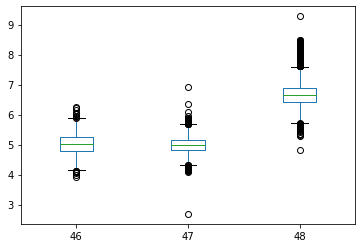

In [19]:
distances_hinge.plot.box()

In [20]:
distances_hinge_sorted = distances_hinge.sort_values(by=[48, 47, 46], ascending=False).head()

In [21]:
index_list = list(distances_hinge_sorted.iloc[[0, -1]].index) + [klifs_metadata_reference.index[0]]

distances_hinge[
    distances_hinge.index.isin(index_list)
]

residues,46,47,48
id,,,
1430,5.757893,6.357279,9.280369
2818,5.199810,5.275187,6.284184
6102,5.238595,5.260629,8.442288


In [22]:
get_cgo_filename_from_metadata_index(2818)

'refpoints_DYRK1A_2wo6_altB_chainB.py'

In [23]:
get_cgo_filename_from_metadata_index(1430)

'refpoints_CK2a1_5m44_chainA.py'

In [24]:
get_cgo_filename_from_metadata_index(5887)

'refpoints_CK2a1_5cvg_altB_chainA.py'

### DFG region

In [25]:
distances_dfg = get_distances(reference_points, hinge_dfg_ca, 'dfg_region')

Not processed: 4104
Not processed: 4109
Not processed: 9830
Not processed: 1541
Not processed: 1504
Not processed: 9595
Not processed: 6189
Not processed: 8746
Not processed: 2208
Not processed: 3492
Not processed: 4837
Not processed: 2953
Not processed: 3059
Not processed: 5963
Not processed: 1399
Not processed: 3673
Not processed: 2176
Not processed: 2163
Not processed: 2167
Not processed: 2191
Not processed: 2181
Not processed: 2172
Not processed: 2076
Not processed: 274
Not processed: 305
Not processed: 301
Not processed: 254
Not processed: 6125
Not processed: 2678
Not processed: 6410
Not processed: 9021
Not processed: 9051
Not processed: 6057
Not processed: 1362
Not processed: 5993
Not processed: 8663
Not processed: 6990
Not processed: 9564
Not processed: 7590
Not processed: 6938
Not processed: 975
Not processed: 8494
Not processed: 190
Not processed: 7523
Not processed: 407
Not processed: 2278
Not processed: 5021
Not processed: 578
Not processed: 9144
Not processed: 9158
Not proc

In [26]:
distances_dfg.head()

residues,81,82,83
id,,,
2886,5.871567,5.628594,3.899856
10043,5.952672,5.499512,3.653353
7046,5.962430,5.643425,4.404388
843,6.940532,7.071506,5.337049
815,6.765899,7.743944,6.582526


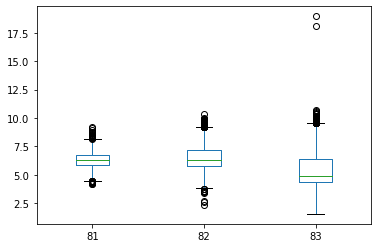

In [27]:
distances_dfg.plot.box()

In [28]:
distances_dfg.sort_values(by=[83, 82, 81], ascending=False).head()

residues,81,82,83
id,,,
7170,6.861162,7.408181,18.958419
1593,6.987313,6.971888,18.082801
6867,7.098741,10.364892,10.696183
3826,7.340665,9.533544,10.643996
9666,7.467104,9.710361,10.558241


## Get centroids

In [29]:
klifs_metadata_reference.index[0]

2818

In [30]:
centroid_2ow6 = reference_points.loc[klifs_metadata_reference.index[0]].centroid
centroid_2ow6

coordinate
x     1.308126
y    21.000233
z    36.178935
Name: centroid, dtype: float64

In [31]:
# Distance centroids to reference centroid
centroid_distances = {}

for metadata_id, coordinates in reference_points.centroid.groupby(level='id', sort=False):
    
    centroid_distances[metadata_id] = scipy.linalg.norm(coordinates - centroid_2ow6)

In [32]:
centroid_distances = pd.Series(centroid_distances, name='Distance centroids to reference centroid')

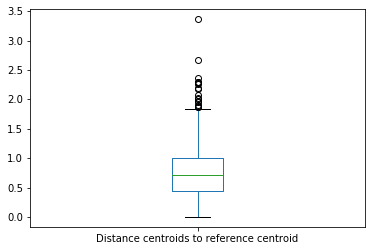

In [33]:
centroid_distances.plot.box()

In [34]:
centroid_distances.sort_values(ascending=False).head(10)

1399    3.362770
2302    2.677713
209     2.369276
255     2.296427
236     2.288158
720     2.270849
7169    2.256087
1593    2.201147
609     2.175758
3977    2.068222
Name: Distance centroids to reference centroid, dtype: float64

## Visualize reference points (PyMol)

In [35]:
def save_refpoints_as_cgo(klifs_metadata):
    
    for index, row in klifs_metadata.iterrows():

        # Load structural data
        ml = KlifsMoleculeLoader(klifs_metadata_entry=row)

        # Calculate spatial features
        spatial = SpatialFeatures()
        spatial.from_molecule(ml.molecule)

        spatial.save_cgo_refpoints(row, output_path='/home/dominique/Desktop/cgo_refpoints/')